<a href="https://colab.research.google.com/github/SachinPrasanth777/flask-app/blob/main/Inventory_Demand_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Zillow.csv')
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,target
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940


In [3]:
df.shape

(77613, 59)

In [4]:
remove = []
for col in df.columns:
  if df[col].nunique == 1:
    remove.append(col)
  elif (df[col].isnull()).mean()>0.60:
    remove.append(col)
print(len(remove))

29


In [5]:
df.drop(remove,axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   bathroomcnt                   77579 non-null  float64
 2   bedroomcnt                    77579 non-null  float64
 3   buildingqualitytypeid         49809 non-null  float64
 4   calculatedbathnbr             76963 non-null  float64
 5   calculatedfinishedsquarefeet  77378 non-null  float64
 6   finishedsquarefeet12          73923 non-null  float64
 7   fips                          77579 non-null  float64
 8   fullbathcnt                   76963 non-null  float64
 9   heatingorsystemtypeid         49571 non-null  float64
 10  latitude                      77579 non-null  float64
 11  longitude                     77579 non-null  float64
 12  lotsizesquarefeet             69321 non-null  float64
 13  p

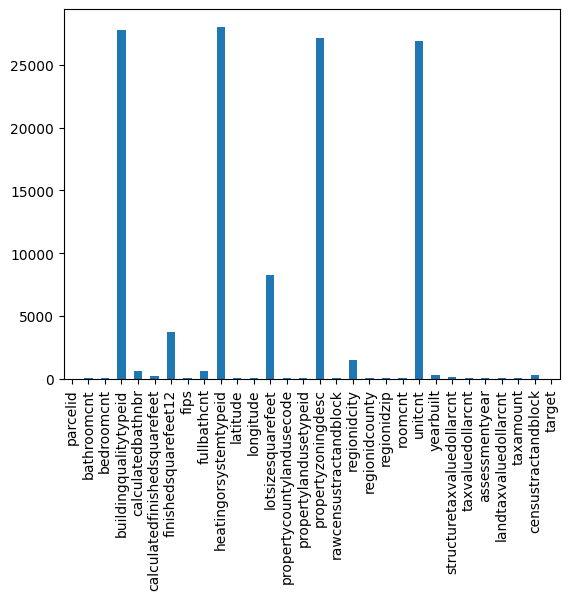

In [6]:
df.isnull().sum().plot.bar()
plt.show()

In [7]:
for col in df.columns:
  if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
  elif df[col].dtype == np.number:
        df[col] = df[col].fillna(df[col].mean())
df.isnull().sum().sum()

0

In [8]:
ints , objects , floats = [],[],[]
for col in df.columns:
  if df[col].dtype == int:
    ints.append(col)
  elif df[col].dtype == float:
    floats.append(col)
  elif df[col].dtype == object:
    objects.append(col)
print(len(ints),len(floats),len(objects))

1 27 2


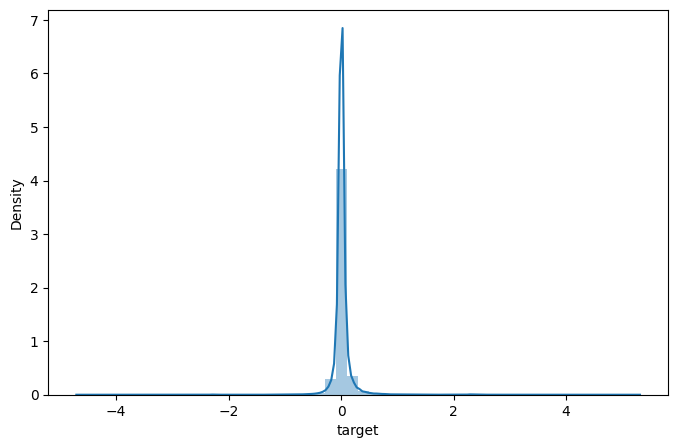

In [9]:
plt.figure(figsize=(8,5))
sns.distplot(df['target'])
plt.show()

In [11]:
z_score = np.abs(zscore(df['target']))
outlier_count = (z_score > 3).sum(axis=0)
print(outlier_count)
df['target'] = np.where(z_score > 3, 3, df['target'])
print("After Outlier Treatment")
df.head()

1137
After Outlier Treatment


,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,target
0,14297519,3.5,4.0,6.533779,3.5,3100.0,3100.0,6059.0,3.0,3.921749,...,0.0,1.110309,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595
1,17052889,1.0,2.0,6.533779,1.0,1465.0,1465.0,6111.0,1.0,3.921749,...,5.0,1.110309,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619
2,14186244,2.0,3.0,6.533779,2.0,1243.0,1243.0,6059.0,2.0,3.921749,...,6.0,1.110309,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383
3,12177905,3.0,4.0,8.000000,3.0,2376.0,2376.0,6037.0,3.0,2.000000,...,0.0,1.000000,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410
4,10887214,3.0,3.0,8.000000,3.0,1312.0,1312.0,6037.0,3.0,2.000000,...,0.0,1.000000,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940


In [12]:
for cols in objects:
  le = LabelEncoder()
  df[cols] = le.fit_transform(df[cols])

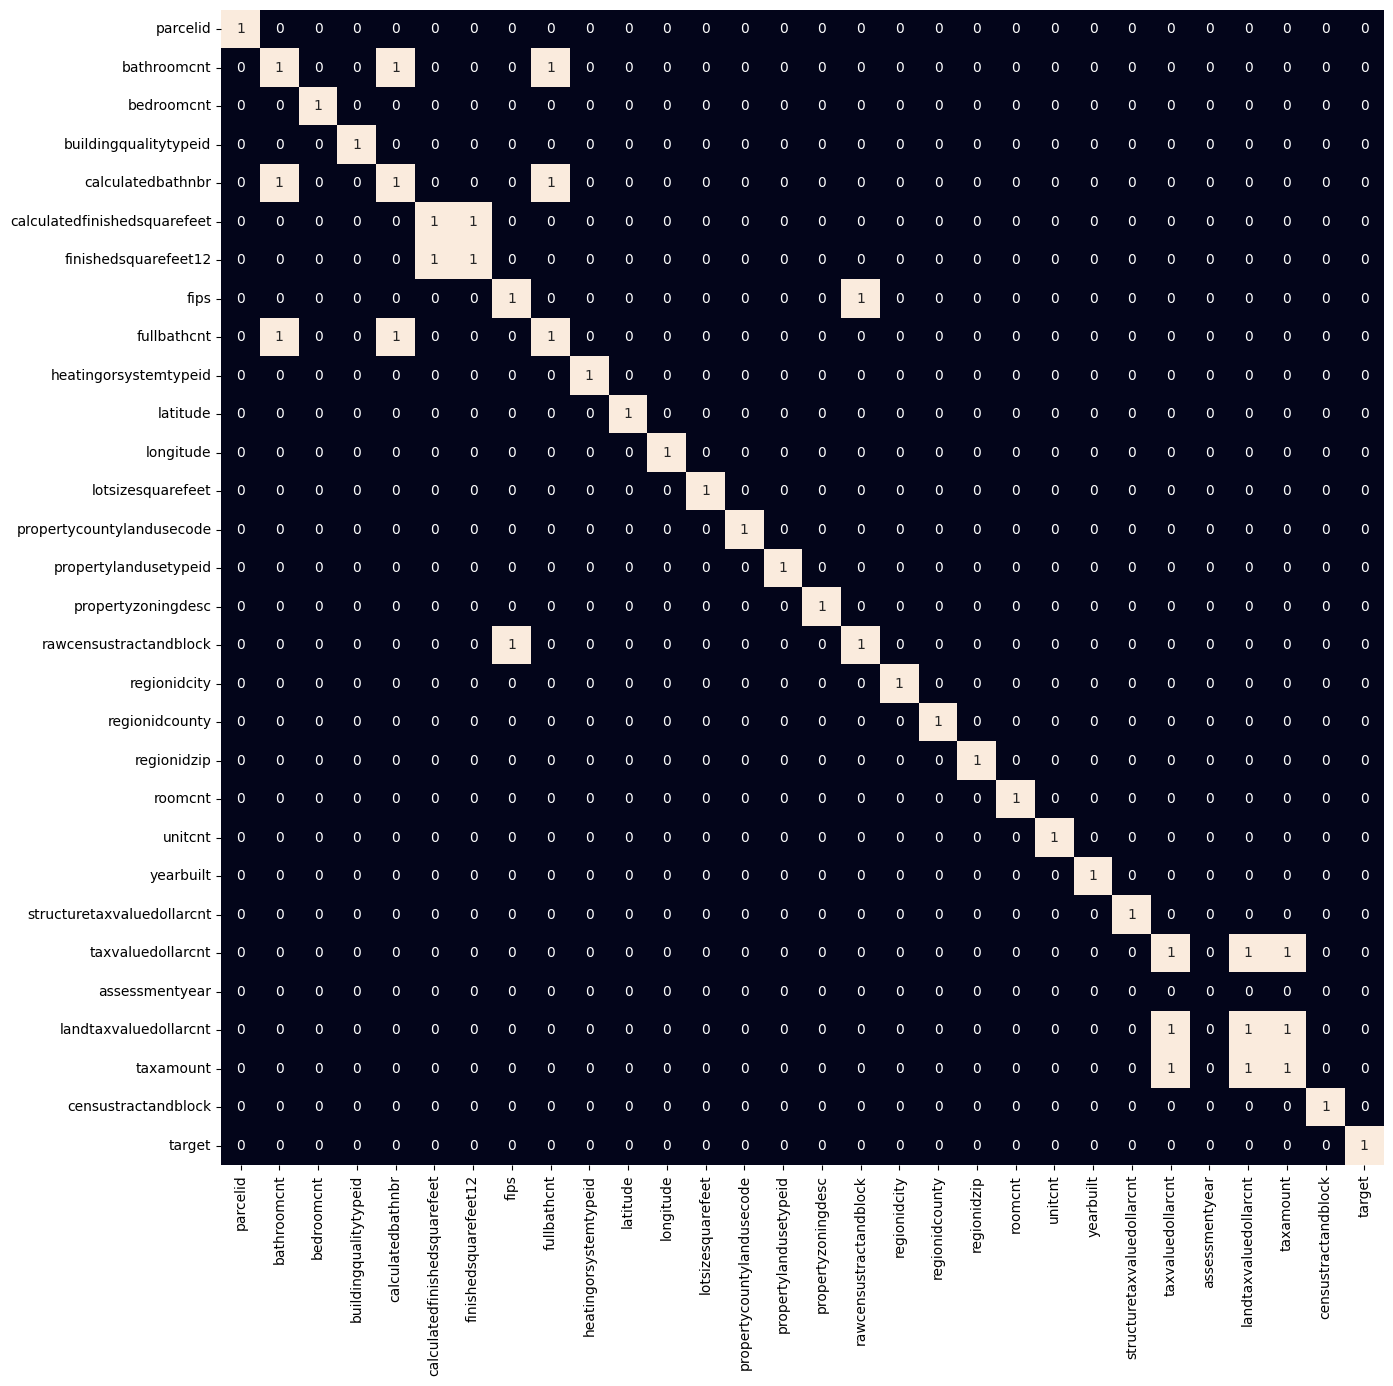

In [13]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

In [18]:
to_remove = ['calculatedbathnbr', 'fullbathcnt', 'fips',
             'rawcensustractandblock', 'taxvaluedollarcnt',
             'finishedsquarefeet12', 'landtaxvaluedollarcnt']
df.drop(to_remove, axis=1, inplace=True)

In [19]:
features = df.drop(['parcelid'], axis=1)
target = df['target'].values
X_train, X_val,Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.1,
                                      random_state=22)
X_train.shape, X_val.shape

((69851, 22), (7762, 22))

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [21]:
from sklearn.metrics import mean_absolute_error as mae
models = [LinearRegression(), XGBRegressor(),
          Lasso(), RandomForestRegressor(), Ridge()]

for i in range(5):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  1.9034857751901003e-16
Validation Error :  1.9364618581067616e-16

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  0.0057450199688793505
Validation Error :  0.015122037681655785

Lasso() : 
Training Error :  0.11517198810025724
Validation E